In [16]:
import scipy.sparse

def laplacian_matrix(n, m):   
    mat_D = scipy.sparse.lil_matrix((m, m))
    mat_D.setdiag(-1, -1)
    mat_D.setdiag(4)
    mat_D.setdiag(-1, 1)
        
    mat_A = scipy.sparse.block_diag([mat_D] * n).tolil()
    
    mat_A.setdiag(-1, 1*m)
    mat_A.setdiag(-1, -1*m)
    
    return mat_A

laplacian_matrix(3, 3).todense()

matrix([[ 4., -1.,  0., -1.,  0.,  0.,  0.,  0.,  0.],
        [-1.,  4., -1.,  0., -1.,  0.,  0.,  0.,  0.],
        [ 0., -1.,  4.,  0.,  0., -1.,  0.,  0.,  0.],
        [-1.,  0.,  0.,  4., -1.,  0., -1.,  0.,  0.],
        [ 0., -1.,  0., -1.,  4., -1.,  0., -1.,  0.],
        [ 0.,  0., -1.,  0., -1.,  4.,  0.,  0., -1.],
        [ 0.,  0.,  0., -1.,  0.,  0.,  4., -1.,  0.],
        [ 0.,  0.,  0.,  0., -1.,  0., -1.,  4., -1.],
        [ 0.,  0.,  0.,  0.,  0., -1.,  0., -1.,  4.]])

Source image size: (337, 404)


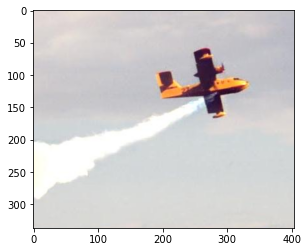

Target image size: (337, 404)


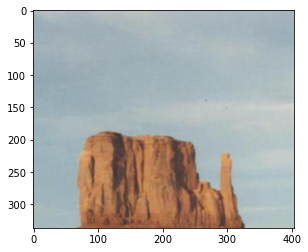

Mask size: (337, 404)


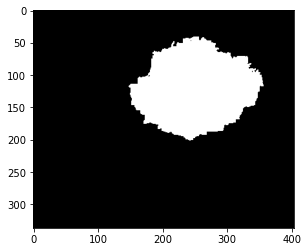

In [25]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

source = cv2.imread("s.png") 
target = cv2.imread("t.png")
mask = cv2.imread("Mask.png", cv2.IMREAD_GRAYSCALE) 
offset = (0,0)
target = cv2.resize(target,(source.shape[1],source.shape[0]),interpolation = cv2.INTER_AREA)

print('Source image size:', source.shape[:-1])
plt.imshow(source[:,:,::-1]) # this is a trick to display the image in here 
plt.show()
print('Target image size:', target.shape[:-1])
plt.imshow(target[:,:,::-1])
plt.show()
print('Mask size:', mask.shape)
plt.imshow(mask, cmap='gray')
plt.show()

Source image size: (337, 404)


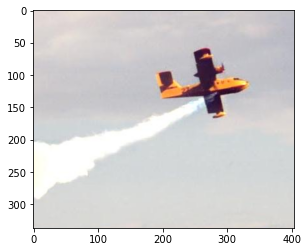

In [13]:
y_max, x_max = source.shape[:-1]
y_min, x_min = 0, 0
x_range = x_max - x_min
y_range = y_max - y_min

M = np.float32([[1, 0, offset[0]], [0, 1, offset[1]]])
source = cv2.warpAffine(source, M, (x_range, y_range))

print('Source image size:', source.shape[:-1])
plt.imshow(source[:,:,::-1]) 
plt.show()

Convert the mask's value to {0, 1} (it was {0, 255}): 

In [17]:
mask = mask[y_min:y_max, x_min:x_max]
mask[mask != 0] = 1

Now we need to generate the matrix $\mathbf{A}$. First, apply our function to get the Laplacian matrix:

In [18]:
mat_A = laplacian_matrix(y_range, x_range)
laplacian = mat_A.tocsc()

In [19]:
for y in range(1, y_range - 1):
    for x in range(1, x_range - 1):
        if mask[y, x] == 0:
            k = x + y * x_range
            mat_A[k, k] = 1
            mat_A[k, k + 1] = 0
            mat_A[k, k - 1] = 0
            mat_A[k, k + x_range] = 0
            mat_A[k, k - x_range] = 0
mat_A = mat_A.tocsc()

Now

In [20]:
from scipy.sparse.linalg import spsolve
mask_flat = mask.flatten()    
for channel in range(source.shape[2]):
    source_flat = source[y_min:y_max, x_min:x_max, channel].flatten()
    target_flat = target[y_min:y_max, x_min:x_max, channel].flatten()        

    # inside the mask:
    # \Delta f = div v = \Delta g       
    alpha = 1
    mat_b = laplacian.dot(source_flat)*alpha

    # outside the mask:
    # f = t
    mat_b[mask_flat == 0] = target_flat[mask_flat == 0]
    x_cg = cg(mat_A, mat_b)    
    x = spsolve(mat_A, mat_b)    
    x = x.reshape((y_range, x_range))
    x[x > 255] = 255
    x[x < 0] = 0
    x = x.astype('uint8')
    
    target[y_min:y_max, x_min:x_max, channel] = x

In [30]:
import time
from scipy.sparse.linalg import cg
t0 = time.time()
x_cg = cg(mat_A, mat_b)
print(time.time() - t0)

0.5955538749694824


In [31]:
t0 = time.time()
x = spsolve(mat_A, mat_b)
print(time.time() - t0)

0.1897296905517578


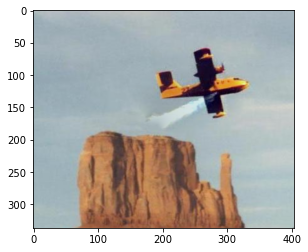

In [21]:
plt.imshow(target[:,:,::-1]) 
plt.show()